In [1]:
import pandas as pd
import ccxt
import requests
from datetime import datetime, timedelta

In [2]:
# Aqui definire una funcion para hacer la extraccion de los datos y darle un correcto formato:

def symbol_data(symbol = 'SOLUSDT', timeframe = '1d', since = (datetime.today() - timedelta(days=1000)).strftime('%Y-%m-%d')):
    exchange = ccxt.bybit({'timeout': 100000,'rateLimit': 1200,})
    ts = int(datetime.timestamp(datetime.strptime(since, '%Y-%m-%d'))*1000)
    aux1 = exchange.fetch_ohlcv(symbol = symbol, since = ts, timeframe=timeframe, limit=1000)
    aux2 = pd.DataFrame(aux1, columns=['date', 'open', 'high', 'low','close','volume'])
    aux2['date'] = pd.to_datetime(aux2['date'], unit = 'ms')
    return aux2

In [3]:
# Aqui definire una funcion para saber cual es el sentimiento del mercado en ese momento:

url = 'https://api.alternative.me/fng/'
params = {'limit':1000,
          'format':'json',
          'date_format':'kr'}

request = requests.get(url=url, params=params)
aux1 = request.json()
sentiment = pd.DataFrame(aux1['data'])


In [4]:
symbol = 'DOGE/USDT'
data = symbol_data(symbol=symbol)
sentiment = sentiment.iloc[::-1].reset_index(drop=True)

df = pd.concat([data, sentiment], axis=1)
df = df[['date','open',	'high',	'low',	'close', 'volume', 'value',	'value_classification']]

In [5]:
# En este bloque de código importamos los indicadores técnicos que estaremos utilizando:
import numpy as np
from ta.momentum import RSIIndicator as RSI
from ta.trend import MACD, ADXIndicator
from ta.others import DailyReturnIndicator, DailyLogReturnIndicator
from ta.volatility import AverageTrueRange, DonchianChannel
from ta.volume import VolumeWeightedAveragePrice

In [6]:
# Aquí simplemente le agregamos los datos de los indicadores técnicos a nuestro conjunto de datos:

df_ind = df.copy()

df_ind['rsi'] = RSI(df_ind['close']).rsi()
df_ind['macd'] = MACD(df_ind['close']).macd()
df_ind['adx'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx()
df_ind['adp'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx_pos()
df_ind['adm'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx_neg()
df_ind['dri'] = DailyReturnIndicator(df_ind['close']).daily_return()
df_ind['dlogri'] = DailyLogReturnIndicator(df_ind['close']).daily_log_return()
df_ind['avgtr'] = AverageTrueRange(df_ind['high'], df_ind['low'], df_ind['close']).average_true_range()
df_ind['donch_hband'] = DonchianChannel(df_ind['high'],df_ind['low'],df_ind['close']).donchian_channel_hband()
df_ind['donch_lband'] = DonchianChannel(df_ind['high'],df_ind['low'],df_ind['close']).donchian_channel_lband()
df_ind['vwap'] = VolumeWeightedAveragePrice(df_ind['high'],df_ind['low'],df_ind['close'], df_ind['volume']).volume_weighted_average_price()

### Ahora vamos a correr el modelo usando los datos de esta nueva crypto para ver como se desempeña.
### El modelo utilizado fue el que se encuentra en modelos_dummys_ver4.0 y el notebook es red_neuronal_mlp.ipynb


In [7]:
import os
os.chdir('C:/Users/POZOLE/Documents/pp/nohtyp/practice_algo_trading/modelos_dummys_ver4.1')
from ft_transformer_model import torch,model, scaler # type: ignore

# Supongamos que "df_df_ind" es un DataFrame con la misma estructura que "data" pero sin la columna 'signals'
df_df_ind = df_ind.copy()  # Asegúrate de trabajar sobre una copia

# Seleccionar las columnas de características
features = ['open', 'value', 'rsi', 'macd', 'adx', 'adp', 'adm', 'dri',
            'dlogri', 'avgtr', 'donch_hband', 'donch_lband', 'vwap']

# Preparar los nuevos datos
X_nuevos = df_ind[features]
X_nuevos = X_nuevos.dropna()

# Normalizar usando el mismo scaler que se ajustó en el entrenamiento
X_nuevos_scaled = scaler.transform(X_nuevos)

# Convertir los datos a tensores de PyTorch
X_nuevos_tensor = torch.tensor(X_nuevos_scaled, dtype=torch.float32)

# Realizar predicciones en los nuevos datos
model.eval()  # Establecer el modelo en modo de evaluación (desactiva el dropout y batch normalization)
with torch.no_grad():  # Desactivar el cálculo de gradientes
    outputs = model(X_nuevos_tensor)  # Obtener las salidas del modelo
    predicciones = torch.argmax(outputs, dim=1)  # Obtener las predicciones (la clase con mayor probabilidad)

# Añadir las predicciones al DataFrame
df_df_ind = df_df_ind.loc[X_nuevos.index]  # Asegura que coincidan los índices
df_df_ind["predicted_signals"] = predicciones.numpy()  # Convertir las predicciones a un array de numpy



c:\Users\POZOLE\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 0.7902
Epoch 2/50, Loss: 0.7065
Epoch 3/50, Loss: 0.6313
Epoch 4/50, Loss: 0.5930
Epoch 5/50, Loss: 0.5670
Epoch 6/50, Loss: 0.5753
Epoch 7/50, Loss: 0.5601
Epoch 8/50, Loss: 0.5464
Epoch 9/50, Loss: 0.5391
Epoch 10/50, Loss: 0.5286
Epoch 11/50, Loss: 0.5174
Epoch 12/50, Loss: 0.5167
Epoch 13/50, Loss: 0.5017
Epoch 14/50, Loss: 0.4989
Epoch 15/50, Loss: 0.5008
Epoch 16/50, Loss: 0.4894
Epoch 17/50, Loss: 0.4939
Epoch 18/50, Loss: 0.4851
Epoch 19/50, Loss: 0.5099
Epoch 20/50, Loss: 0.4774
Epoch 21/50, Loss: 0.4879
Epoch 22/50, Loss: 0.4659
Epoch 23/50, Loss: 0.4608
Epoch 24/50, Loss: 0.4545
Epoch 25/50, Loss: 0.4632
Epoch 26/50, Loss: 0.4844
Epoch 27/50, Loss: 0.4741
Epoch 28/50, Loss: 0.4751
Epoch 29/50, Loss: 0.4652
Epoch 30/50, Loss: 0.4606
Epoch 31/50, Loss: 0.4415
Epoch 32/50, Loss: 0.4340
Epoch 33/50, Loss: 0.4315
Epoch 34/50, Loss: 0.4415
Epoch 35/50, Loss: 0.4288
Epoch 36/50, Loss: 0.4282
Epoch 37/50, Loss: 0.4134
Epoch 38/50, Loss: 0.4636
Epoch 39/50, Loss: 0.

In [8]:
import numpy as np

# Opcional: convertir las predicciones numéricas de vuelta a texto
inverse_mapping = {0: 'buy', 1: 'sell', 2: 'hold'}
df_df_ind['predictions_text'] = df_df_ind['predicted_signals'].map(inverse_mapping)

# Si 'predicted_signals' está en df_df_ind, haz lo siguiente:
df_df_ind['buy_signal'] = np.where(df_df_ind['predictions_text'] == 'buy', 1, 0)
df_df_ind['sell_signal'] = np.where(df_df_ind['predictions_text'] == 'sell', 1, 0)


In [9]:
df_df_ind.head(n=60)

,date,open,high,low,close,volume,value,value_classification,rsi,macd,...,dri,dlogri,avgtr,donch_hband,donch_lband,vwap,predicted_signals,predictions_text,buy_signal,sell_signal
25,2022-08-01,0.06806,0.07128,0.06684,0.06846,57499587.5,39,Fear,52.678448,0.000113,...,0.587717,0.585996,0.004489,0.07697,0.05746,0.068810,2,hold,0,0
26,2022-08-02,0.06846,0.06910,0.06546,0.06650,26109194.0,33,Fear,47.595882,0.000019,...,-2.862986,-2.904769,0.004428,0.07697,0.05949,0.068805,2,hold,0,0
27,2022-08-03,0.06650,0.06843,0.06509,0.06627,20401927.1,31,Fear,47.022542,-0.000073,...,-0.345865,-0.346464,0.004351,0.07697,0.06010,0.068164,2,hold,0,0
28,2022-08-04,0.06627,0.06761,0.06573,0.06721,29840130.5,34,Fear,49.689910,-0.000069,...,1.418440,1.408474,0.004174,0.07697,0.06010,0.068012,2,hold,0,0
29,2022-08-05,0.06721,0.07027,0.06720,0.06983,34438558.5,30,Fear,56.295031,0.000144,...,3.898229,3.824167,0.004095,0.07697,0.06010,0.068049,2,hold,0,0
30,2022-08-06,0.06983,0.07131,0.06842,0.06855,27465463.1,31,Fear,52.657715,0.000207,...,-1.833023,-1.850031,0.004009,0.07697,0.06010,0.068121,1,sell,0,1
31,2022-08-07,0.06855,0.06998,0.06737,0.06893,17652726.4,31,Fear,53.615876,0.000284,...,0.554340,0.552809,0.003909,0.07697,0.06010,0.068148,2,hold,0,0
32,2022-08-08,0.06893,0.07255,0.06883,0.07007,37832750.7,30,Fear,56.462677,0.000432,...,1.653852,1.640325,0.003896,0.07697,0.06010,0.068528,1,sell,0,1
33,2022-08-09,0.07007,0.07426,0.06773,0.06902,72037632.7,30,Fear,53.222617,0.000460,...,-1.498501,-1.509842,0.004084,0.07450,0.06010,0.069020,1,sell,0,1
34,2022-08-10,0.06902,0.07144,0.06658,0.07127,46194930.4,42,Fear,58.692727,0.000655,...,3.259925,3.207916,0.004139,0.07450,0.06010,0.069311,2,hold,0,0


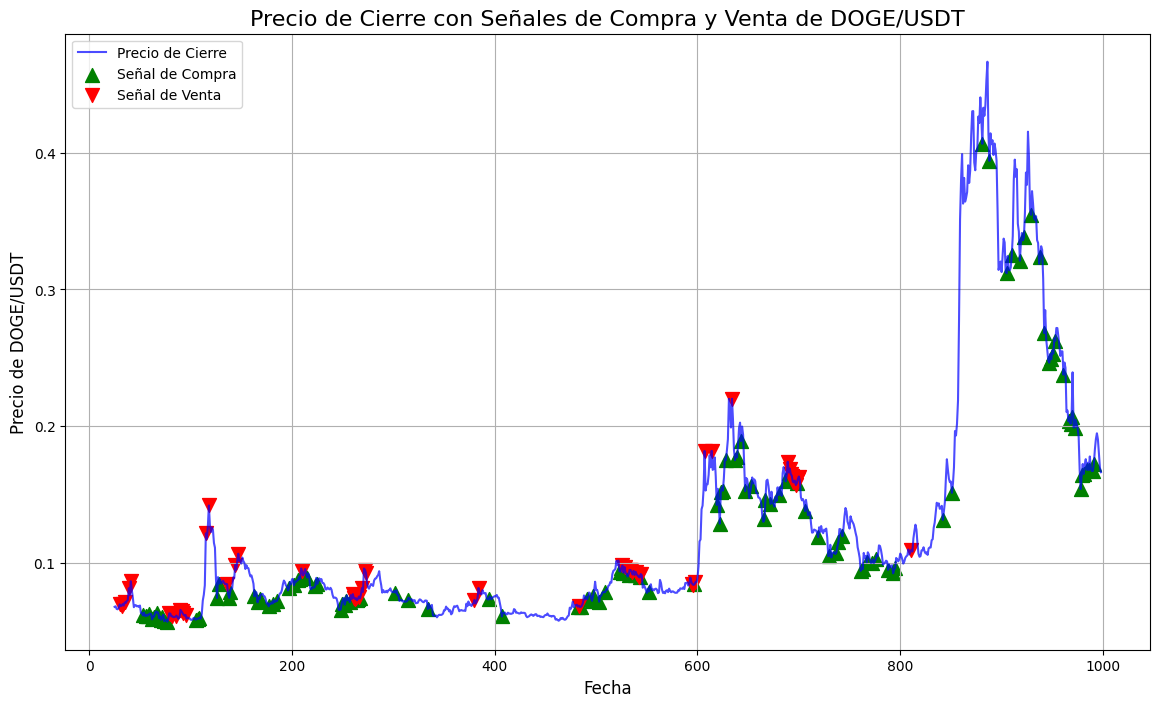

In [10]:
import matplotlib.pyplot as plt

# Crear gráfico de precios
plt.figure(figsize=(14, 8))
plt.plot(df_df_ind['open'], label='Precio de Cierre', color='blue', alpha=0.7)

# Añadir señales de compra y venta
plt.scatter(df_df_ind.index[df_df_ind['buy_signal'] == 1], df_df_ind['open'][df_df_ind['buy_signal'] == 1], 
            marker='^', color='green', label='Señal de Compra', alpha=1, s=100)
plt.scatter(df_df_ind.index[df_df_ind['sell_signal'] == 1], df_df_ind['open'][df_df_ind['sell_signal'] == 1], 
            marker='v', color='red', label='Señal de Venta', alpha=1, s=100)

# Personalización del gráfico
plt.title(f'Precio de Cierre con Señales de Compra y Venta de {symbol}', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Precio de {symbol}', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Mostrar gráfico
plt.show()

Compra a 0.0618 en 2022-08-29 00:00:00
Venta a 0.06334 en 2022-09-24 00:00:00 | ROI: 2.49%
Compra a 0.05866 en 2022-10-20 00:00:00
Venta a 0.1217 en 2022-10-30 00:00:00 | ROI: 107.47%
Compra a 0.07452 en 2022-11-10 00:00:00
Venta a 0.08455 en 2022-11-20 00:00:00 | ROI: 13.46%
Compra a 0.07463 en 2022-11-22 00:00:00
Venta a 0.09869 en 2022-11-28 00:00:00 | ROI: 32.24%
Compra a 0.07574 en 2022-12-17 00:00:00
Venta a 0.09401 en 2023-02-02 00:00:00 | ROI: 24.12%
Compra a 0.09101 en 2023-02-03 00:00:00
Venta a 0.07734 en 2023-03-24 00:00:00 | ROI: -15.02%
Compra a 0.07287 en 2023-03-28 00:00:00
Venta a 0.07557 en 2023-03-30 00:00:00 | ROI: 3.71%
Compra a 0.07421 en 2023-03-31 00:00:00
Venta a 0.0818 en 2023-04-02 00:00:00 | ROI: 10.23%
Compra a 0.07839 en 2023-05-05 00:00:00
Venta a 0.0732 en 2023-07-22 00:00:00 | ROI: -6.62%
Compra a 0.07347 en 2023-08-05 00:00:00
Venta a 0.06894 en 2023-11-02 00:00:00 | ROI: -6.17%
Compra a 0.06809 en 2023-11-04 00:00:00
Venta a 0.09832 en 2023-12-15 00:0

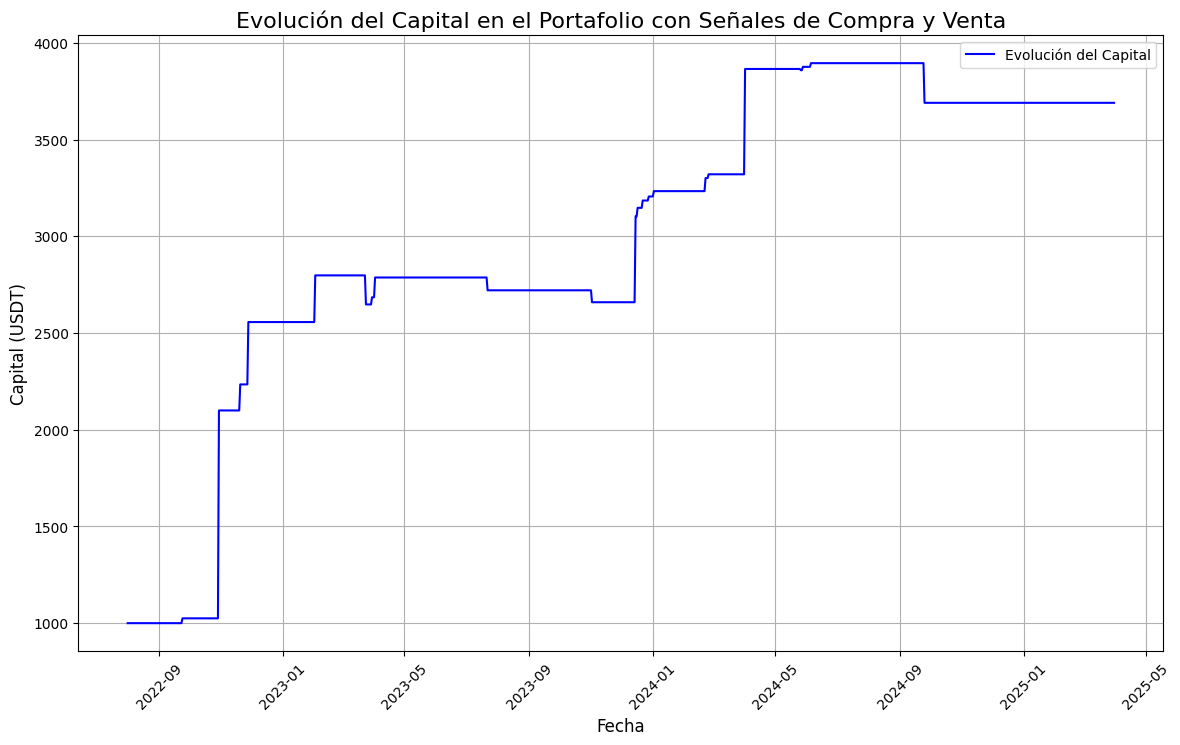

In [11]:
import pandas as pd

# Crear una copia del DataFrame
df = df_df_ind.copy()

# Inicializar las variables
capital_inicial = 1000  # Ejemplo de inversión inicial en USDT
capital = capital_inicial  # Capital actualizado durante las operaciones
buy_price = 0  # Precio al que se compró el activo
holding = False  # Estado de si se tiene una posición abierta

# Listas para almacenar resultados
capital_history = []  # Historial del capital a lo largo del tiempo
buy_prices = []  # Historial de precios de compra
sell_prices = []  # Historial de precios de venta

# Iterar a través de las filas del DataFrame
for index, row in df.iterrows():
    # Señal de compra
    if row['buy_signal'] == 1 and not holding:
        buy_price = row['open']
        holding = True  # Se abre la posición
        buy_prices.append(buy_price)
        print(f"Compra a {buy_price} en {df['date'][index]}")
    
    # Señal de venta
    elif row['sell_signal'] == 1 and holding:
        sell_price = row['open']
        roi = (sell_price - buy_price) / buy_price  # Cálculo del ROI
        capital += capital_inicial * roi  # Actualización del capital
        sell_prices.append(sell_price)
        holding = False  # Se cierra la posición
        print(f"Venta a {sell_price} en {df['date'][index]} | ROI: {roi*100:.2f}%")
    
    capital_history.append(capital)  # Guardar capital actual

# Imprimir el capital final
print(f"Capital final: {capital:.2f} USDT")

# Opcional: Crear un DataFrame para visualizar el historial de capital
df_capital = pd.DataFrame({
    'Date': df['date'],
    'Capital': capital_history
})

# Graficar la evolución del capital a lo largo del tiempo
plt.figure(figsize=(14, 8))
plt.plot(df_capital['Date'], df_capital['Capital'], label='Evolución del Capital', color='blue')
plt.title('Evolución del Capital en el Portafolio con Señales de Compra y Venta', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Capital (USDT)', fontsize=12)
plt.grid(True)
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.show()


Capital Final: 1000.26 USDT
Tasa de Retorno Acumulado: 0.03%
Volatilidad Anualizada: 0.7729
Relación de Sharpe: -0.0103
Drawdown Máximo: -0.03%


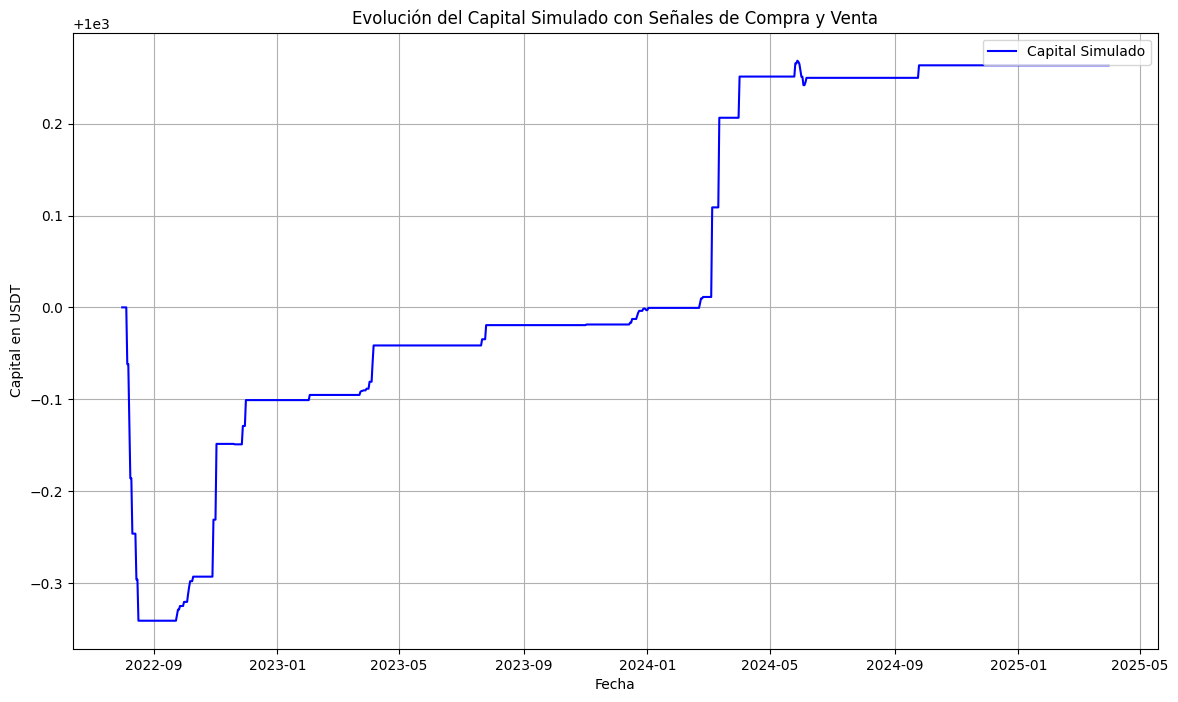

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Supongamos que tienes los datos necesarios con las señales predichas
# Aquí se toma el dataframe 'df_df_ind' con las señales de compra y venta predichas

# Asegúrate de que las fechas estén en el formato correcto
df_df_ind['date'] = pd.to_datetime(df_df_ind['date'])
df_df_ind.sort_values('date', inplace=True)

# Calcula el retorno diario en base al precio 'open'
df_df_ind['daily_return'] = df_df_ind['open'].pct_change()

# Calcula el retorno acumulado de la inversión
initial_capital = 1000  # Capital inicial
df_df_ind['capital'] = initial_capital * (1 + df_df_ind['daily_return']).cumprod()

# Simular las compras y ventas
capital = initial_capital
capital_series = []

for i in range(len(df_df_ind)):
    if df_df_ind['buy_signal'].iloc[i]:
        buy_price = df_df_ind['open'].iloc[i]
    if df_df_ind['sell_signal'].iloc[i]:
        sell_price = df_df_ind['open'].iloc[i]
        capital += (sell_price - buy_price)  # Calcular el retorno de la venta
    capital_series.append(capital)

df_df_ind['capital_simulado'] = capital_series

# 1. Calcular el Drawdown
df_df_ind['capital_max'] = df_df_ind['capital_simulado'].cummax()
df_df_ind['drawdown'] = df_df_ind['capital_simulado'] - df_df_ind['capital_max']
df_df_ind['drawdown_pct'] = df_df_ind['drawdown'] / df_df_ind['capital_max'] * 100

# 2. Calcular la volatilidad (desviación estándar de los retornos diarios)
volatilidad = df_df_ind['daily_return'].std() * np.sqrt(252)  # Volatilidad anualizada

# 3. Calcular la rentabilidad diaria promedio
rentabilidad_diaria = df_df_ind['daily_return'].mean()

# 4. Calcular la relación de Sharpe
tasa_libre_riesgo = 0.01  # Asumimos una tasa libre de riesgo del 1%
sharpe_ratio = (rentabilidad_diaria - tasa_libre_riesgo) / volatilidad

# 5. Resultado Final
capital_final = df_df_ind['capital_simulado'].iloc[-1]
tasa_retorno_acumulado = (capital_final - initial_capital) / initial_capital * 100

# Imprimir métricas de desempeño
print(f"Capital Final: {capital_final:.2f} USDT")
print(f"Tasa de Retorno Acumulado: {tasa_retorno_acumulado:.2f}%")
print(f"Volatilidad Anualizada: {volatilidad:.4f}")
print(f"Relación de Sharpe: {sharpe_ratio:.4f}")
print(f"Drawdown Máximo: {df_df_ind['drawdown_pct'].min():.2f}%")

# Graficar la evolución del capital simulado
plt.figure(figsize=(14, 8))
plt.plot(df_df_ind['date'], df_df_ind['capital_simulado'], label='Capital Simulado', color='blue')
plt.title('Evolución del Capital Simulado con Señales de Compra y Venta')
plt.xlabel('Fecha')
plt.ylabel('Capital en USDT')
plt.grid(True)
plt.legend()
plt.show()


In [13]:
import pandas as pd

# Crear una copia del DataFrame
df = df_df_ind.copy()

# Inicializar las variables
capital_inicial = 1000  # Ejemplo de inversión inicial en USDT
capital = capital_inicial  # Capital actualizado durante las operaciones
buy_price = 0  # Precio al que se compró el activo
holding = False  # Estado de si se tiene una posición abierta

# Tarifa de Bybit (comisiones de maker y taker)
maker_fee = 0.0001  # 0.01% en cada compra (maker)
taker_fee = 0.00075  # 0.075% en cada venta (taker)

# Listas para almacenar resultados
capital_history = []  # Historial del capital a lo largo del tiempo
buy_prices = []  # Historial de precios de compra
sell_prices = []  # Historial de precios de venta

# Iterar a través de las filas del DataFrame
for index, row in df.iterrows():
    # Señal de compra
    if row['buy_signal'] == 1 and not holding:
        buy_price = row['open'] * (1 + maker_fee)  # Ajustar por la comisión maker
        holding = True  # Se abre la posición
        buy_prices.append(buy_price)
        print(f"Compra a {buy_price:.2f} en {df['date'][index]}")
    
    # Señal de venta
    elif row['sell_signal'] == 1 and holding:
        sell_price = row['open'] * (1 - taker_fee)  # Ajustar por la comisión taker
        roi = (sell_price - buy_price) / buy_price  # Cálculo del ROI
        capital += capital_inicial * roi  # Actualización del capital
        sell_prices.append(sell_price)
        holding = False  # Se cierra la posición
        print(f"Venta a {sell_price:.2f} en {df['date'][index]} | ROI: {roi*100:.2f}%")
    
    capital_history.append(capital)  # Guardar capital actual

# Imprimir el capital final
print(f"Capital final: {capital:.2f} USDT")

# Opcional: Crear un DataFrame para visualizar el historial de capital
df_capital = pd.DataFrame({
    'Date': df['date'],
    'Capital': capital_history
})


Compra a 0.06 en 2022-08-29 00:00:00
Venta a 0.06 en 2022-09-24 00:00:00 | ROI: 2.40%
Compra a 0.06 en 2022-10-20 00:00:00
Venta a 0.12 en 2022-10-30 00:00:00 | ROI: 107.29%
Compra a 0.07 en 2022-11-10 00:00:00
Venta a 0.08 en 2022-11-20 00:00:00 | ROI: 13.36%
Compra a 0.07 en 2022-11-22 00:00:00
Venta a 0.10 en 2022-11-28 00:00:00 | ROI: 32.13%
Compra a 0.08 en 2022-12-17 00:00:00
Venta a 0.09 en 2023-02-02 00:00:00 | ROI: 24.02%
Compra a 0.09 en 2023-02-03 00:00:00
Venta a 0.08 en 2023-03-24 00:00:00 | ROI: -15.09%
Compra a 0.07 en 2023-03-28 00:00:00
Venta a 0.08 en 2023-03-30 00:00:00 | ROI: 3.62%
Compra a 0.07 en 2023-03-31 00:00:00
Venta a 0.08 en 2023-04-02 00:00:00 | ROI: 10.13%
Compra a 0.08 en 2023-05-05 00:00:00
Venta a 0.07 en 2023-07-22 00:00:00 | ROI: -6.70%
Compra a 0.07 en 2023-08-05 00:00:00
Venta a 0.07 en 2023-11-02 00:00:00 | ROI: -6.25%
Compra a 0.07 en 2023-11-04 00:00:00
Venta a 0.10 en 2023-12-15 00:00:00 | ROI: 44.27%
Compra a 0.09 en 2023-12-16 00:00:00
Venta 